In [1]:
import numpy as np
import os, sys
import csv
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload
import io
from os import path



import scipy
import scipy.signal as signal
from scipy.fft import fft, fftfreq
from scipy.stats import skew, kurtosis, ttest_ind, ttest_rel
import re
from collections import OrderedDict


# Data slicing for one picture 

In [2]:
def data_slicing(input_directory, destination, eval_mode = None, participant = None):
    i = 0
    
    #print(os.listdir(input_directory))

    for phase in os.listdir(input_directory):
        if phase.find(".DS_Store") != -1: continue

        directory = input_directory + phase +"/"

        for filename in os.listdir(directory):
            i += 1
            if filename.find('txt') == -1: continue
            
            if eval_mode == True:
                label = filename[filename.find(participant):]
            else:
                if phase.find("test") != -1 or phase.find("high") != -1:
                    label = 'high'
                elif phase.find("medium") != -1:
                    label = 'medium'
                elif phase.find("low") != -1:
                    label = 'low'

            df = np.loadtxt(directory+filename, dtype = 'str', delimiter = ',')

            result = []

            for row in df:
                for iteration in range(5):
                    temp = row[iteration*NUM_ELECTRODES+2:(iteration+1)*NUM_ELECTRODES+2].astype(float)
                    temp = temp*1000/24 #Conversion from mV to uV
                    result.append(temp)

            result = np.array(result)  

            #Be careful when you cut time
            #result = result[hz*time_to_cut:-hz*time_to_cut]
            np.save(destination+label+str(i)+ ".npy", result)

# FFT & filtering


In [3]:
#Filtering out signals
def notch_filter(data):
    b0,a0 = signal.butter(2, [47.5, 52.5], 'bandstop', fs=250)  #Removing all the signals with frequency 47.5 - 52.5 from the original signal
    data_filt0 = signal.filtfilt(b0, a0, data)

    
    b1,a1 = signal.butter(2, [97.5, 102.5], 'bandstop', fs=250) 
    notch_filter_data = signal.filtfilt(b1, a1, data_filt0)
    return notch_filter_data

#Keeping in signals
def bandpass_filter(data):
    b,a=signal.butter(4,[0.5,45],'bandpass',fs=250)  #Selecting the signals with frequency 0.5 - 32
    notch_filter_data = notch_filter(data)
    band_filter_data=signal.filtfilt(b,a,notch_filter_data)
    return band_filter_data 

In [8]:
#N: length of array T: 1/sampling rate 
'''def FFT(data, N, T):
    print("data.shape",data.shape)
    yf = fft(data)
    xf = fftfreq(N, T)[:N//2] #returns array with length N because it returns the entire 
    
    #print(xf.shape, yf.shape)
    plt.clf()
    #plt.xlim(0,35)
    plt.plot(xf, 2.0*N * np.abs(yf[0:N//2]))
    plt.show()
    
    return xf, yf

def psd_one(fft_value, freq, band):

    cond_band = np.where((freq >= FREQ_BANDS[band][0]) & (freq <= FREQ_BANDS[band[1]]))
    psd_band = fft_value[:,cond_band].reshape(fft_value.shape[0], -1)
    result = np.sum(psd_band, axis = 1)
    
    return result'''


def psd_c1(array, Fs=hz): # returning the sum delta,theta, alpha, sigma, beta, gamma, R for one channel.
    
    rows = len(array)
    freq = fftfreq(rows, 1/Fs)
    
    #The actual transformation
    fft_value = np.abs(fft(array)[:int(rows/2+0.5)])
    fft_norm = fft_value/(np.sum(fft_value)) #Normalizing
    
    # delta
    cond_delta = np.where((freq>=FREQ_BANDS['delta'][0]) &
                          (freq<=FREQ_BANDS['delta'][1]))
    delta = np.sum(fft_norm[cond_delta])
    # theta
    cond_theta = np.where((freq>=FREQ_BANDS['theta'][0]) &
                          (freq<=FREQ_BANDS['theta'][1]))
    theta = np.sum(fft_norm[cond_theta])
    # alpha
    cond_alpha = np.where((freq>=FREQ_BANDS['alpha'][0]) &
                          (freq<=FREQ_BANDS['alpha'][1]))
    alpha = np.sum(fft_norm[cond_alpha])
    # sigma
    cond_sigma = np.where((freq>=FREQ_BANDS['sigma'][0]) &
                          (freq<=FREQ_BANDS['sigma'][1]))
    sigma = np.sum(fft_norm[cond_sigma])
    # beta
    cond_beta = np.where((freq>=FREQ_BANDS['beta'][0]) &
                          (freq<=FREQ_BANDS['beta'][1]))
    beta = np.sum(fft_norm[cond_beta])
    # gamma
    cond_gamma = np.where((freq>=FREQ_BANDS['gamma'][0]) &
                          (freq<=FREQ_BANDS['gamma'][1]))
    gamma = np.sum(fft_norm[cond_gamma])
    
    # R
    R = (alpha + sigma) / beta
    
    return np.array([delta, theta, alpha, sigma, beta, gamma, R])


# PSD

In [5]:
def feature_processing(input_directory, destination, eval_mode = None, participant = None):
    id = 0

    for filename in os.listdir(input_directory):

        if filename.find('DS_Store') != -1: continue
            
        raw_eeg = np.load(input_directory+filename)

        if filename.find('low') != -1:
            gt = np.array([1])
        elif filename.find('medium') != -1:
            gt = np.array([5])
        elif filename.find('high') != -1:
            gt = np.array([10])
        elif eval_mode == True:
            gt = np.array([0])
            name = filename[filename.find(participant):]

        m = raw_eeg.shape[0]
        n = raw_eeg.shape[1]
        raw_eeg = raw_eeg.reshape((n,m))
                
        filtered_eeg = bandpass_filter(raw_eeg)

        #Grabbing the 7 PSD values of each electrode
        psd_one = psd_c1(filtered_eeg[0])
        psd_two = psd_c1(filtered_eeg[1])
        psd_three = psd_c1(filtered_eeg[2])
        psd_four = psd_c1(filtered_eeg[3])
        psd_five = psd_c1(filtered_eeg[4])
        
        min_f = np.min(filtered_eeg, axis=1)
        max_f = np.max(filtered_eeg, axis=1)
        avg_f = np.mean(filtered_eeg, axis=1)
        var_f = np.var(filtered_eeg, axis=1)
        med_f = np.median(filtered_eeg, axis=1)

        #Should return shape of 1 X 61 (1+5X5+5X7)

        features = np.concatenate([gt,min_f, max_f, avg_f, var_f, med_f, psd_one, psd_two, psd_three, psd_four,psd_five]).reshape(-1,61)

        if eval_mode == True:
            np.save(destination+str(name)+".npy", features.squeeze())
        else:
            np.save(destination +str(id)+".npy", features.squeeze())
        id += 1

   
        

In [33]:
def comparison_feature_extraction(input_directory, destination):
    
    high = []
    low = []
    for filename in os.listdir(input_directory):

        if filename.find('DS_Store') != -1: continue
        if filename.find('.sav') != -1: continue
            
        features = np.load(input_directory+filename, allow_pickle = True)
        
        if features[0] == 10:
            high.append(features)
        else:
            low.append(features)
        
    high = np.array(high)
    low = np.array(low)
    
    id = 0
    
    result_features = []
    feature_difference = []
    
    #print("High", high)
    #print("low", low)
    
    
    
    for idx,example_high in enumerate(high):
        
        for idj, example_low in enumerate(low):
        
            if id % 2 == 0:
                feature_difference = np.concatenate([[1], example_high[1:] - example_low[1:]])
            else:
                feature_difference = np.concatenate([[0], example_low[1:] - example_high[1:]])
            np.save(destination +str(id)+".npy", feature_difference.squeeze())
            
            
            id += 1
        
        

In [38]:
'''raw_data_path = "./data/eric/tmp/"
clean_data_path = "./data/eric/clean/"
features_data_path = "./data/eric/features/"'''

raw_data_path = "./data/train/tmp/"
clean_data_path = "./data/train/clean/"
features_data_path = "./data/train/features/"
comparison_data_path = "./data/train/comparison_features/"

hz = 250
time_to_cut = 0
NUM_ELECTRODES = 5

#The features we shall extract for our linear regression model

'''FREQ_BANDS = {"slow": [0.7, 2.0],
              "delta": [1, 3.99],
              "theta0": [4, 5.99],
              "theta1": [6, 7.99],
              "theta2": [4, 8.5],
              "alpha0": [8, 9.99],
              "alpha1": [10, 12.99],
              "beta0": [13, 21.49],
              "beta1" : [21.5, 29.99],
              "vertex": [3, 5],
              "spindle": [12, 14]}'''

FREQ_BANDS = {"delta": [0.5 , 4.5],
              "theta": [4.5 , 8.5],
              "alpha": [8.5 , 11.5],
              "sigma": [11.5, 15.5],
              "beta" : [15.5, 30],
              "gamma": [30  , 100] }
FREQ_BANDS = OrderedDict(FREQ_BANDS)


data_slicing(raw_data_path, clean_data_path)
feature_processing(clean_data_path, features_data_path)
comparison_feature_extraction(features_data_path, comparison_data_path)




# Training

In [60]:
import numpy as np
import os, sys
import csv
import pandas as pd
import matplotlib.pyplot as plt
import time, copy
from importlib import reload

import torch
print(torch.__version__)
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import optim, nn

1.8.1


In [61]:
class FeatureDatasetFunction(torch.utils.data.Dataset):
    def __init__(self, data_path, mode, max_path=None, transform=None):
        self.data_path = data_path
        self.transform = transform
        self.mode = mode
        
        train = []
        test = []
        
        #self.max_features = np.load(max_path)
        
        for filename in os.listdir(data_path):
            if filename.find('.DS') != -1: continue
            index = int(filename[:-4])
            if index % 10 == 0:
                test.append(np.load(data_path+filename, allow_pickle = True))
            else:
                train.append(np.load(data_path+filename, allow_pickle = True))
                
        self.data = train if mode == "train" else test
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        #print("HELLO")
        #print("This is shape", np.array(self.data).shape)
        data = self.data[idx][1:].astype(np.float)
        #data = data / self.max_features
        #why are we dividing by the max?
        label = self.data[idx][0]
        #stored as the label
        
        if self.transform != None:
            data = self.transform(label)
        return data, label

In [53]:
train_set = FeatureDatasetFunction(comparison_data_path,"train")
train_loader = DataLoader(train_set, batch_size=16, num_workers=4, shuffle=True)

test_set = FeatureDatasetFunction(comparison_data_path,"test")
test_loader = DataLoader(test_set, batch_size=16, num_workers=4)

dataloaders = {"train": train_loader, "test": test_loader}
dataset_sizes = {"train": len(train_set), "test": len(test_set)}

print(dataset_sizes)
print(len(train_set.__getitem__(100)[0]))

#60 features


{'train': 629, 'test': 70}
60


In [47]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            model.train()
    
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # zero the parameter gradients
                optimizer.zero_grad()
                #print("prev input.shape{}".format(inputs.shape))
                inputs = inputs.float().squeeze()
                #print("after input.shape{}".format(inputs.shape))
                #print("prev labels.shape{}".format(labels.shape))
                labels = labels.float().squeeze()
                #print("after labels.shape{}".format(labels.shape))

                # forward
                # Only calculate gradient for training
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs).squeeze()  
                    #calcuting the loss based on the BCE Criterion
                    loss = criterion(outputs, labels)
                    preds = torch.round(outputs)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels)
                
            if phase == 'train' and scheduler != None:
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [48]:
my_model = nn.Sequential(nn.Linear(60,30,bias=False),nn.Linear(30,10,bias=False), nn.Linear(10,1,bias=False), nn.Sigmoid())
criterion = nn.BCELoss()
print(my_model)

# Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(my_model.parameters(), lr=0.5)
optimizer_ft = optim.Adam(my_model.parameters(),lr=0.05, weight_decay=0.0001)
lr_scheduler = None
# lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=1)

Sequential(
  (0): Linear(in_features=60, out_features=30, bias=False)
  (1): Linear(in_features=30, out_features=10, bias=False)
  (2): Linear(in_features=10, out_features=1, bias=False)
  (3): Sigmoid()
)


In [63]:
final_model = train_model(my_model, 
                                                       criterion, 
                                                       optimizer_ft, 
                                                       lr_scheduler, 
                                                       dataloaders, 
                                                       dataset_sizes,
                                                       num_epochs=10)

Epoch 0/9
----------


PicklingError: Can't pickle <class '__main__.FeatureDatasetFunction'>: it's not the same object as __main__.FeatureDatasetFunction

## Selecting the best features to include

In [662]:
#Figuring out how many features to include
import pickle
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from matplotlib import pyplot

#Returns the ideal number of features to include in the linear regression model
def select_best_features(X_train, y_train, X_test):
    results = []
    num_total_features = X_train.shape[1]
    
    for var in range(num_total_features + 1)[1:]:
        lin_reg_mod = LinearRegression()

        #Trying out different number of features to include
        X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test, var)
        lin_reg_mod.fit(X_train_fs, y_train)
        y_pred= lin_reg_mod.predict(X_test_fs)

        test_set_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        test_set_r2 = r2_score(y_test, y_pred)
        results.append([test_set_r2, var, test_set_rmse])
        
    results = sorted(results)
    #print(results)
        
    return results[-1][1], results

#Returns the X_train_fs, X_test_fs, and the feature selection model itself
def select_features(X_train, y_train, X_test, num_features):
    
    # configure to select all features
    fs = SelectKBest(score_func=f_regression, k = num_features)
    
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.fit_transform(X_train, y_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs



In [663]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
def pca_data(X, X_test, N):
    X = StandardScaler().fit_transform(X)
    X_test = StandardScaler().fit_transform(X_test)
    pca = PCA(n_components = N)
    X = pca.fit_transform(X)
    X_test = pca.fit_transform(X_test)
    print("pca_components * pca_explained_variance", pca.explained_variance_ratio_)
    
    print("Total explained variance, ", np.sum(pca.explained_variance_ratio_))
    return X, X_test, pca

In [664]:
#Gotta save the pca and fs objects locally

X_train, X_test, y_train, y_test = training_data(features_data_path)

print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)


# feature selection for linear regression model
final_num_features, results = select_best_features(X_train, y_train, X_test)
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test, final_num_features)

X_train_pca, X_test_pca, pca_object = pca_data(X_train, X_test, 2)
print(X_train_pca.shape)


Train (24, 60) (24,)
Test (6, 60) (6,)
pca_components * pca_explained_variance [0.47234303 0.23191044]
Total explained variance,  0.7042534668003213
(24, 2)


Best number of features to have is 6


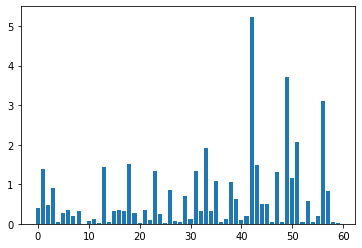

[42 49 56 51 33 18]


In [665]:

print("Best number of features to have is",final_num_features)
#print(X_train_fs.shape, X_test_fs.shape)
#what are scores for the features
#for i in range(len(fs.scores_)):
    #print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

#print(results)
features_included = fs.scores_.argsort()[-final_num_features:][::-1]
print(features_included)

## Finish training the model

In [666]:
lin_reg_mod = LinearRegression()

lin_reg_mod.fit(X_train_fs, y_train)
y_pred= lin_reg_mod.predict(X_test_fs)

#lin_reg_mod.fit(X_train_pca, y_train)
#y_pred= lin_reg_mod.predict(X_test_pca)

print("Prediction: ", y_pred, "Real: ", y_test)

test_set_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_set_r2 = r2_score(y_test, y_pred)

print("Final R2 Score:", test_set_r2, "\n FInal RMSE Score:", test_set_rmse)

model_name = 'finalmodel.sav'
pickle.dump(lin_reg_mod, open(features_data_path+model_name,'wb'))

Prediction:  [3.42074025 6.66569964 6.06288736 4.50125965 7.95202902 2.59166567] Real:  [ 1. 10. 10.  1. 10.  1.]
Final R2 Score: 0.5764213819595321 
 FInal RMSE Score: 2.9287312979034925


# Testing

In [667]:

#y_pred = loaded_model.predict(X_test_fs)
#print(y_pred)

#test_set_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#test_set_r2 = r2_score(y_test, y_pred)

#print(test_set_r2, test_set_rmse)

In [668]:
def testing_data_processing(input_directory, fs, eval_mode = None, pca = None):
    x_final = []
    y_final = []
    
    for filename in os.listdir(input_directory):
        if filename.find('.DS_Store') != -1: continue
            
        data = np.load(input_directory+filename)
        #print(data.shape)
        x = data[1:]
        x_final.append(x.reshape(-1, 1))
        
        if eval_mode == True:
            y = filename
            y_final.append(y)
        else:
            y = data[0]
            y_final.append(y.reshape(-1, 1))


    x_final = np.array(x_final).squeeze()
    
    if eval_mode == True:
        y_final = y_final
    else:
        y_final = np.array(y_final).squeeze()
    
    if pca != None:
        x_final = pca_object.transform(x_final)
    else:
        x_final = fs.transform(x_final)
    
    return x_final, y_final


In [669]:
test_raw_data_path = "./data/eric/test/tmp/"
test_clean_data_path = "./data/eric/test/clean/"
test_features_data_path = "./data/eric/test/features/"
model_path = features_data_path + model_name


def accuracy_evaluation(y_final, y_pred):
    #Figuring out the total comparisions I need to make
    
    #length = float(len(y_final))
    #total_comparisons = 0.5*(length**2 + length)
    comparisons = []
    total = 0
    correct = 0
    
    for idx,val in enumerate(y_final):
        
        if idx == (len(y_final)) - 1: break
        idx2 = idx+1
        
        for idx2 in range(len(y_final)):
            if y_final[idx] > y_final [idx2]:
                total += 1 
                comparisons.append([idx,idx2])
                
    for pair in comparisons:
        if y_pred[pair[0]] > y_pred[pair[1]]:
            correct += 1
    print(correct, total)
    return float(correct)/total


def evaluate_model(test_raw_data_path, test_clean_data_path, test_features_data_path, model_path, eval_mode = None, participant = None, pca = None):
    
    data_slicing(test_raw_data_path, test_clean_data_path, eval_mode, participant)
    feature_processing(test_clean_data_path, test_features_data_path, eval_mode, participant) #filter and PSD data
    if pca != None:
        X_final,y_final = testing_data_processing(test_features_data_path, fs, eval_mode = eval_mode, pca = pca)
    else:
        X_final, y_final = testing_data_processing(test_features_data_path, fs, eval_mode = eval_mode)

    loaded_model = pickle.load(open(model_path, 'rb'))

    print(X_final.shape)
    y_pred = loaded_model.predict(X_final)
    
    #print("y_final",y_final)
    #print(y_pred)
    
    if eval_mode == True:
        predictions = []
        for val in range(len(y_pred)):
            predictions.append([y_pred[val], y_final[val]])
        predictions = sorted(predictions)[::-1]
        
        for elem in predictions:
            print(elem)
        return
    accuracy = accuracy_evaluation(y_final, y_pred)

    test_set_r2 = r2_score(y_final, y_pred)
    print(test_set_r2)
    print("Final comparison accuracy", accuracy)
    
evaluate_model(test_raw_data_path, test_clean_data_path, test_features_data_path, model_path)
#evaluate_model(test_raw_data_path, test_clean_data_path, test_features_data_path, model_path, pca = pca_object)

(9, 6)
12 16
-0.29198337762097193
Final comparison accuracy 0.75


We trained this linear regression model with eric's EEG when he looks at pictures of pretty girls and his score for each girl. Our comparison method, however, involves comparing two the real scores of the pictures and the predicted score of the pictures. 

### 去测试了一下我的朋友george的脑电波

In [670]:

george_raw_data_path = "./data/george/tmp/"
george_clean_data_path = "./data/george/clean/"
george_features_data_path = "./data/george/features/"
model_path = features_data_path + model_name

evaluate_model(george_raw_data_path, george_clean_data_path, george_features_data_path, model_path, eval_mode = True, participant = "George")
#evaluate_model(george_raw_data_path, george_clean_data_path, george_features_data_path, model_path, eval_mode = True, participant = "George", pca = pca_object)

(21, 6)
[13.435484841966842, 'George_aurora.txt26.npy.npy']
[13.43548484196684, 'George_aurora.txt19.npy.npy']
[12.928310561973461, 'George_courtney.txt11.npy.npy']
[8.84358634965543, 'George_DiLiReBa.txt2.npy.npy']
[8.414512775944068, 'George_20210529173742_8s_BrainUp70B4AE2CBDA.txt20.npy.npy']
[7.952029018208597, 'George_liu.txt6.npy.npy']
[7.492056982267195, 'George_jennifer.txt1.npy.npy']
[7.016152900019309, 'George_sherry.txt25.npy.npy']
[7.016152900019309, 'George_sherry.txt18.npy.npy']
[6.078769851308899, 'George_20210529173713_8s_BrainUp70B4AE2CBDA.txt22.npy.npy']
[5.904774734942273, 'George_marg.txt27.npy.npy']
[5.904774734942273, 'George_marg.txt20.npy.npy']
[5.609528883003723, 'George_Diana.txt28.npy.npy']
[5.609528883003723, 'George_Diana.txt21.npy.npy']
[5.24926302186629, 'George_stela.txt30.npy.npy']
[5.24926302186629, 'George_stela.txt23.npy.npy']
[4.897987488559653, 'George_yangzi.txt7.npy.npy']
[4.501259646413079, 'George_20210529173728_8s_BrainUp70B4AE2CBDA.txt24.npy.